# Amundsen SIC Concentrations 
#### Author: Tasha Snow 

Reconstructing SIC concentrations or Wild et al. (in prep) 

In [1]:
%pip install pyhdf -q
%pip install regionmask -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib widget
import os
import numpy as np
import pandas as pd
import xarray as xr
import requests
from bs4 import BeautifulSoup
import re
from concurrent.futures import ThreadPoolExecutor, as_completed
from pyhdf.SD import SD, SDC
# import io
import geopandas as gpd
from shapely.geometry import Point, Polygon
import regionmask
from tqdm import tqdm
import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

In [3]:
def get_file_in_directory(path): 
    "Retrieves file names from a directory \
    \n\nInput: path = directory \
    \n\nOutput: list of subdirectories"

    return [name for name in os.listdir(path)
            if os.path.isfile(os.path.join(path, name))]

def date_from_julian_date(yrj):
    d = datetime.datetime.strptime(yrj, '%Y%j').date()
    return d

def get_ncfile_in_url(urlpath):
    "Retrieves netcdf file names from a URL directory (needs small change to do any file type)\
    \n\nInput: urlpath = HTTPS directory \
    \n\nOutput: list of subdirectories"
    
    r  = requests.get(urlpath)
    data = r.text
    soup = BeautifulSoup(data)

    ncfiles = []
    for link in soup.find_all('a'):
        if link.get('href').endswith('.nc'):
            ncfiles.append(link.get('href'))
    return ncfiles

def download_https(urlpath,outfiles,outpath):
    'Download files from a URL directory (needs small change to do any file type)\
    \n\nInput: urlpath = HTTPS directory \
               outfiles = list of file names in directory \
               outpath = output directory for downloading'
    for outfile in outfiles:
        urllib.request.urlretrieve(urlpath+'/'+outfile,outpath+'/'+outfile)

# Sea ice land masking
Needed to use 3.25km AMSR-2 sea ice concentration w NO LAND MASK because their land mask sucks, so created own land mask here

In [4]:
base_url = 'https://data.seaice.uni-bremen.de/amsr2/asi_daygrid_swath/s3125/'

# Function to get the content of a given URL
def get_soup(url):
    response = requests.get(url)
    response.raise_for_status()
    return BeautifulSoup(response.text, 'html.parser')

# Function to extract all TIFF file URLs from a given directory URL
def extract_hdf_urls(directory_url):
    soup = get_soup(directory_url)
    return [directory_url + link['href'] for link in soup.find_all('a', href=True) if link['href'].endswith('.hdf')]

# Function to recursively find all TIFF files in a given base URL
def find_all_files(base_url):
    all_urls = []
    soup = get_soup(base_url)
    year_urls = [base_url + link['href'] for link in soup.find_all('a', href=True) if re.match(r'\d{4}/', link['href'])]

    with ThreadPoolExecutor(max_workers=10) as executor:
        future_to_url = {executor.submit(get_soup, year_url): year_url for year_url in year_urls}

        for future in as_completed(future_to_url):
            year_url = future_to_url[future]
            try:
                year_soup = future.result()
                month_urls = [year_url + link['href'] for link in year_soup.find_all('a', href=True) if not link['href'].startswith('?') and not link['href'].startswith('/amsr2')]
                
                with ThreadPoolExecutor(max_workers=10) as month_executor:
                    month_futures = {month_executor.submit(get_soup, month_url): month_url for month_url in month_urls}
                    
                    for month_future in as_completed(month_futures):
                        month_url = month_futures[month_future]
                        try:
                            month_soup = month_future.result()
                            area_urls = [month_url + link['href'] for link in month_soup.find_all('a', href=True) if link['href'] == 'Antarctic3125NoLandMask/']
                            
                            with ThreadPoolExecutor(max_workers=10) as area_executor:
                                area_futures = {area_executor.submit(extract_hdf_urls, area_url): area_url for area_url in area_urls}
                                
                                for area_future in as_completed(area_futures):
                                    all_urls.extend(area_future.result())
                        except Exception as e:
                            print(f"Exception occurred for URL {month_url}: {e}")
            except Exception as e:
                print(f"Exception occurred for URL {year_url}: {e}")

    return all_urls

In [5]:
def download_hdf4(url,var='ASI Ice Concentration'):
    '''
    Function to download the HDF4 file into memory and save it temporarily to disk
    '''
    # Download the file since pyhdf cannot open an hdf4 streaming
    response = requests.get(url)
    file_name = url.split('/')[-1]
    with open(file_name, 'wb') as file:
        file.write(response.content)
    
    # Open the file with pyhdf
    hdf_file = SD(file_name, SDC.READ)
    # for key in hdf_file.datasets(): print (key)
    SIC = hdf_file.select(var)[:]
    
    # Clean up the local file
    os.remove(file_name)
    return SIC

# Define a function to calculate pixel areas based on latitude
def calculate_pixel_areas(latitudes, resolution_km):
    """
    Calculate the area of each pixel based on latitude.
    latitudes: DataArray corresponding to grid points.
    resolution_km: The spatial resolution of the grid (e.g., 3.125 km for AMSR-2).
    """
    earth_radius_km = 6371.0  # Earth's radius in kilometers

    # Calculate pixel area, considering latitude
    latitudes_rad = np.deg2rad(latitudes)
    pixel_area = (resolution_km * resolution_km * np.cos(latitudes_rad))  # Area shrinks as cos(latitude)
    
    return pixel_area

def hdf4_sic(url,mlat,mlon,masklandice1,bbox):
    '''
    Extracts sea ice concentration from an hdf4 url that is downloaded and opened.
    '''
    # Download and open
    SIC = download_hdf4(url)
    SIC_xr = xr.DataArray(SIC,dims=['y','x'],coords={"latitude": (['y','x'], mlat),"longitude": (['y','x'], mlon)})
    dt_obj = datetime.datetime.strptime(url[-17:-9], '%Y%m%d')

    # Mask land and ice shelf
    SIC_xr = SIC_xr.where(masklandice1.values!=1)

    # Create boolean masks for the desired latitude and longitude ranges
    lat_mask = (SIC_xr.latitude >= bbox[3]) & (SIC_xr.latitude <= bbox[1])
    lon_mask = (SIC_xr.longitude >= bbox[0]) & (SIC_xr.longitude <= bbox[2])
    
    # Combine masks
    combined_mask = lat_mask & lon_mask

    # Use the combined mask to select data within the range and drop the coordinates that are not needed
    SIC_xr = SIC_xr.where(combined_mask, drop=True)

    # Compute the mean concentration along the latitude and longitude dimensions
    mean_concentration = SIC_xr.mean(dim=['y', 'x'])

    return dt_obj.strftime('%Y-%m-%d'), round(mean_concentration.values.item(),1)

In [10]:
%%time
# Find all TIFF files under Antarctic3125NoLandMask
SICurls = find_all_files(base_url)
print(len(base_url))

64
CPU times: user 5.57 s, sys: 304 ms, total: 5.87 s
Wall time: 1min 33s


In [ ]:
# Get lat/lon grids

# URL of the dataset
url = 'https://data.seaice.uni-bremen.de/grid_coordinates/s3125/LongitudeLatitudeGrid-s3125-Antarctic3125.hdf'
file_path = f'./{url[-45:]}'

# Download the file since pyhdf cannot open an hdf4 streaming
response = requests.get(url)
with open(file_path, 'wb') as file:
    file.write(response.content)

# Open the file with pyhdf
grids = SD(file_path, SDC.READ)
for key in grids.datasets(): print (key)

# Clean up the local file
os.remove(file_path)

mlat, mlon = grids.select('Latitudes')[:], grids.select('Longitudes')[:]
mlon = np.where(mlon > 180, mlon - 360, mlon)

In [7]:
# Create land and ice shelf masks for the SIC data
coastline = '~/shared/add_coastline_polygon_high_v7_2_202005_SCAR/add_coastline_polygon_high_v7_2_202005.shp'

# Define points for the bounding box (in WGS 84 coordinates)
p1 = Point(-122, -70.5)
p2 = Point(-122, -76.2)
p3 = Point(-94.0, -76.2)
p4 = Point(-94.0, -70.5)

# Convert to tuples for the Polygon and create a bounding box Polygon from the points
np1 = (p1.coords.xy[0][0], p1.coords.xy[1][0])
np2 = (p2.coords.xy[0][0], p2.coords.xy[1][0])
np3 = (p3.coords.xy[0][0], p3.coords.xy[1][0])
np4 = (p4.coords.xy[0][0], p4.coords.xy[1][0])

bb_polygon = Polygon([np1, np2, np3, np4])

# Create a GeoDataFrame from the bounding box Polygon
map_extent = gpd.GeoDataFrame(gpd.GeoSeries(bb_polygon), columns=['geometry'])

# Read the shapefile, convert to wgs 84, and clip the shelf data to the bounding box
shelf = gpd.read_file(coastline)
shelf = shelf.to_crs(epsg=4326)
shelf_clip = gpd.clip(shelf,map_extent)
shelf_clip = shelf_clip[~shelf_clip.is_empty]

# Select both 'land' and 'ice shelf' surface types from the clipped data and add together
land = shelf_clip.loc[shelf_clip['surface'] == 'land']
ice = shelf_clip.loc[shelf_clip['surface'] == 'ice shelf']
landice = shelf_clip.loc[(shelf_clip['surface'] == 'land')|(shelf_clip['surface'] == 'ice shelf')]

/tmp/ipykernel_306/1482273829.py:24: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  shelf_clip = gpd.clip(shelf,map_extent)


In [8]:
# Make mask for grounded plus ice shelves

# Ice shelf mask
maskice = regionmask.mask_geopandas(ice, mlon, mlat,lon_name='longitude',lat_name='latitude')
maskice1 = maskice.where(~(maskice>=0),1)

# Grounded ice mask
maskland = regionmask.mask_geopandas(land, mlon, mlat,lon_name='longitude',lat_name='latitude')
maskland1 = maskland.where(~(maskland>=0),1)

# Ice shelf + grounded ice mask
masklandice = regionmask.mask_geopandas(landice, mlon, mlat,lon_name='longitude',lat_name='latitude')
masklandice1 = masklandice.where(~(masklandice>=0),1)

/srv/conda/envs/notebook/lib/python3.11/site-packages/regionmask/core/mask.py:179: FutureWarning: Passing 'lon_name' and 'lat_name' was deprecated in v0.10.0. Please pass the coordinates directly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.11/site-packages/regionmask/core/mask.py:179: FutureWarning: Passing 'lon_name' and 'lat_name' was deprecated in v0.10.0. Please pass the coordinates directly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.11/site-packages/regionmask/core/mask.py:179: FutureWarning: Passing 'lon_name' and 'lat_name' was deprecated in v0.10.0. Please pass the coordinates directly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  warnings.warn(


In [19]:
# Pine Island Bay bounding box
ulx = -106
uly = -74.5
lrx = -102
lry = -75
bbox = [ulx,uly,lrx,lry]

# Years to search (must be end year + 1 to search end year)
start = 2020
end = 2023
years = range(start,end)
print(years)

range(2020, 2023)


In [20]:
# Create SIC timeseries (don't need to do if already have the pandas dataframe csv)
amsr = []

# Read in all days for sea ice concentration in 2020-2022
urls = [i for i in SICurls if int(i.split('/')[6]) in years]
for url in tqdm(urls):
    dt_obj, mean_concentration = hdf4_sic(url,mlat,mlon,masklandice1,bbox)
    amsr.append([dt_obj, mean_concentration])

# Read in Jan 2023
urls = [i for i in SICurls if '202301' in i]
for url in tqdm(urls):
    dt_obj, mean_concentration = hdf4_sic(url,mlat,mlon,masklandice1,bbox)
    amsr.append([dt_obj, mean_concentration])

100%|██████████| 31/31 [01:14<00:00,  2.42s/it]


In [21]:
csv_file = '/home/jovyan/Data/PIB_SIC_20200101_20230131.csv'

df = pd.read_csv(csv_file)
df.set_index('Datetime', inplace=True)
df.index = pd.to_datetime(df.index)

if 'amsr' in globals():
    # DataFrame creation
    df = pd.DataFrame(amsr, columns=['Datetime', 'SIC[%]'])
    
    # Convert 'Datetime' column to datetime format (if it's not already)
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    
    # Set 'Datetime' as the index
    df.set_index('Datetime', inplace=True)
    
    # Sort the DataFrame by the datetime index and save
    df = df.sort_index()
    df.to_csv(csv_file)

else:
    df = pd.read_csv(csv_file)
    df.set_index('Datetime', inplace=True)
    df.index = pd.to_datetime(df.index)

df.head()

,SIC[%]
Datetime,
2020-01-01,41.3
2020-01-02,39.5
2020-01-03,38.2
2020-01-04,37.4
2020-01-05,35.7


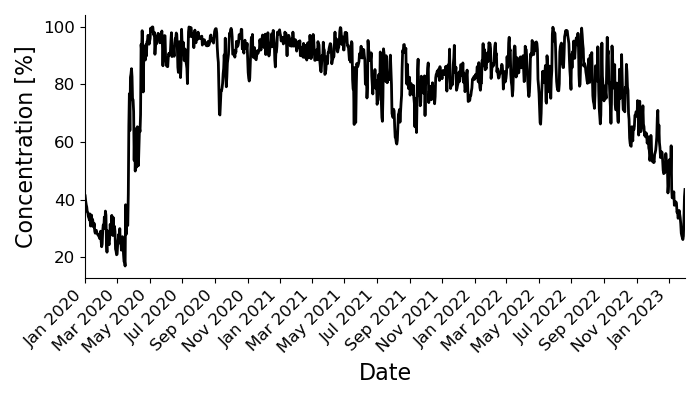

In [22]:
# Plot timeseries of sea ice concentration
fig, ax = plt.subplots(figsize=(7, 4))
ax.tick_params(labelsize=12)

# Plotting the data
ax.plot(df.index, df['SIC[%]'], color='k', linewidth=2, label='Sea Ice Concentration')

# Removing unnecessary spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Setting the axis labels
ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('Concentration [%]', fontsize=16)

# Set the x-axis to start on January 1, 2020
start_date = pd.Timestamp('2020-01-01')
end = df.index.max()
ax.set_xlim([start_date, end])  # Set start date and use the max date from the data

# # Set major ticks every 2 months, starting from January 2020
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # Show every 2 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format as 'Jan 2020', 'Mar 2020', etc.

# Ensure January 2020 is the first tick by setting the minimum tick value
ax.set_xticks(pd.date_range(start=start_date, end=df.index.max(), freq='2MS'))  # 2MS: 1st of every 2 months

# Rotate the x-axis labels by 45 degrees
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
# Show the plot
plt.show()

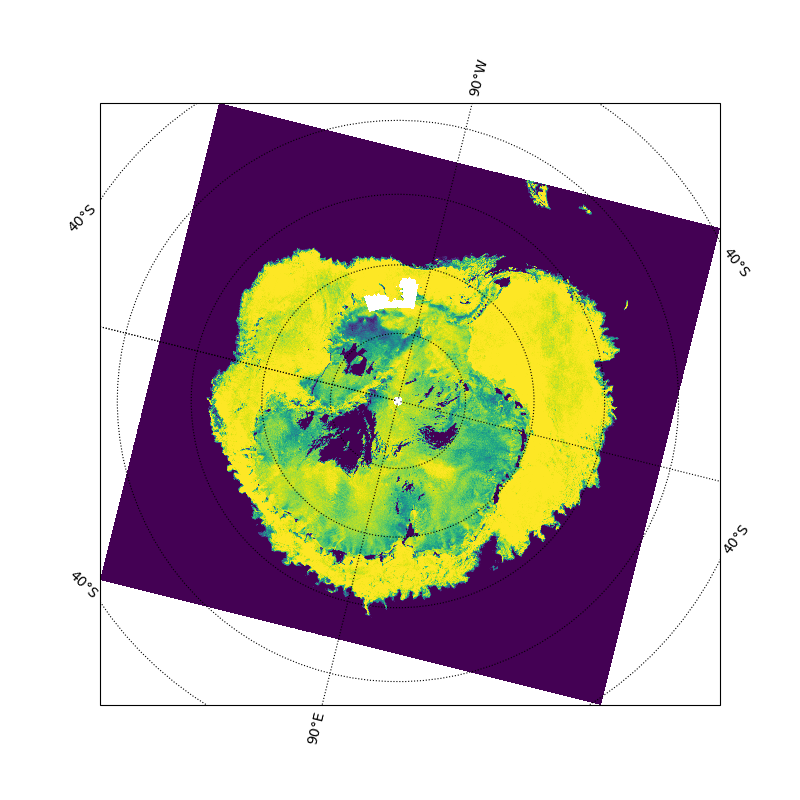

In [176]:
# # Testing - Visualize to ensure mask was added appropriately
# f, ax = plt.subplots(figsize=(8,8),subplot_kw=dict(projection=ccrs.SouthPolarStereo(central_longitude=-104.0)))
# ax.pcolormesh(SIC_xr.longitude,SIC_xr.latitude,SIC_xr.data,cmap="viridis",transform=ccrs.PlateCarree())
# ax.gridlines(draw_labels=True,xlocs=[-180,-90,0,90,180],ylocs=[-80,-70,-60,-50,-40],y_inline=False,color='k',linestyle=':')